In [49]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np
import math
from os import path

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
def phase_kickback(circ, t, phase):
    '''
    First part of PEA, consisting on applying repeated
    controlled U gates in order to kickback the phase
    to the first register
    '''
    for i in range(t):
        circ.h(i)
        for j in range(2**(t-1-i)):
            circ.cu1(2*np.pi*phase, i, -1)
    circ.barrier()
    
def inv_qft(circ, t):
    '''
    Second part of PEA, applying the inverse QFT
    to the first register of t qubits
    '''
    for i in range(math.floor(int(t/2))):
        circ.swap(i, t-1-i)
    for i in range(t):
        for j in range(i):
            circ.cu1(-2*np.pi/2**(i+1-j), t-j-1, t-1-i)
        circ.h(t-i-1)
    circ.barrier()

# UTILITY FUNCTIONS    

def bf_to_dec(s):
    '''
    Convert binary fraction to decimal
    '''
    n = 0.
    for i in range(len(s)):
        n += float(s[i])*2**(-(i+1))
    return n

def p(theta, phase):
    '''
    Theoretical probability distribution if the phase can't be expressed in binary fraction notation.
        - theta: is an estimation of the phase
        - phase: the phase that we want to estimate
    '''
    return np.sin(2**t*np.pi*(theta-phase))**2/(2**(2*t)*np.sin(np.pi*(theta-phase))**2)

In [126]:
# PEA implementation

phase = 1./3

t = 4 # number of qubits for storing the phase estimation

circ = QuantumCircuit(t+1, t)
circ.x(-1) # Prepare the eigenstate
phase_kickback(circ, t, phase)
inv_qft(circ, t)

# measure the first register
# reverse measuring order to get correct formatting
for i in range(t):
    circ.measure(i, t-1-i)

#circ.draw(output='mpl')

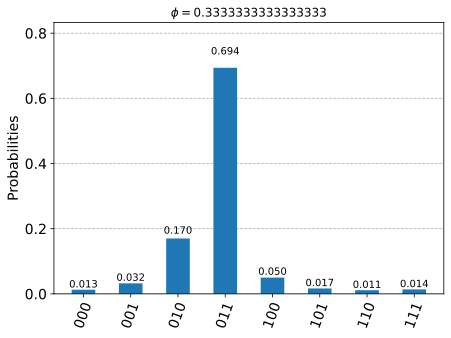

In [115]:
# RUN THIS BLOCK FOR SIMULATING
backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(circ, backend=backend, shots=shots).result()
answer = results.get_counts()

%config InlineBackend.figure_format = 'svg'
plot_histogram(answer, title=r'$\phi = {}$'.format(phase), color='C0')

In [79]:
# RUN THIS BLOCK FOR RUNNING THE CIRCUIT ON A REAL QUANTUM COMPUTER
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend_qc = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= t+1 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend_qc)

ibmqfactory.load_account:WARNING:2020-05-04 19:51:24,504: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_ourense


In [ ]:
provider = IBMQ.load_account()
backend_qc = provider.backends.ibmq_essex

job_exp = execute(circ, backend=backend_qc, shots=shots)
job_monitor(job_exp)
result = job_exp.result()
answer = result.get_counts()
plot_histogram(answer, title=r'$\phi = {}$'.format(phase), color='C0').savefig('PEA-essex-bf-t3')

ibmqfactory.load_account:WARNING:2020-05-04 21:13:03,484: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job is actively running

In [ ]:
#plt.style.use('seaborn')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

answer_dec = {bf_to_dec(key):value/shots for key, value in zip(answer.keys(), answer.values())}

t_answer_dec = {key:p(key, phase) for key in answer_dec.keys()}

plt.rc('axes', axisbelow=True)
plt.grid(axis='y', linestyle='--')

rect = plt.bar(answer_dec.keys(), answer_dec.values(), width=0.05, label='Experimental')
autolabel(rect)
plt.bar(t_answer_dec.keys(), t_answer_dec.values(), alpha=0.5, width=0.025, color='red', label='Theoretical')
plt.xticks(list(answer_dec.keys()), list(answer.keys()), rotation=75)
plt.legend()
plt.ylabel('Probabilities')

plt.savefig('PEA-essex-nbf-t4')

In [ ]:
# AVERAGE RULE: Take most probable value as an estimation
print('MAJORITY RULE')
print()
est_phase = max(answer_dec, key=answer_dec.get)
print('Estimated phase: {}'.format(est_phase))
print('Probability: {}'.format(max(answer_dec.values())))
print('Phase: {}'.format(round(phase, 3)))
acc = np.abs(est_phase - phase)
print('Accuracy: {}'.format(round(acc, 3), acc_n))
print('2^-(t+1) = {}'.format(2**(-(t+1))))

In [ ]:
# AVERAGE RULE: Use circular statistics to get an estimation


def mu(phase):
    A = 2**t -1
    return np.arctan((A*np.sin(2*np.pi*phase)-np.sin(A*2*np.pi*phase))/(A*np.cos(2*np.pi*phase) + np.cos(A*2*np.pi*phase)))/(2*np.pi)

def mu2(phase):
    A = 2**t -1
    return np.arctan2((A*np.sin(2*np.pi*phase)-np.sin(A*2*np.pi*phase)), (A*np.cos(2*np.pi*phase)+ np.cos(A*2*np.pi*phase)))/(2*np.pi)

def rho(phase):
    A = 2**t - 1
    return np.sqrt(4**(-t)*(4**t - 2**(t+1)+2+2*A*np.cos(2**(t+1)*np.pi*phase)))

# First trigonometric moment about the mean direction

theta_1 = np.sum([value*np.exp(2*np.pi*1j*key) for key, value in zip(answer_dec.keys(), answer_dec.values())])


est_phase = np.angle(theta_1)/(2*np.pi)

print('Estimated phase: {}'.format(est_phase))
print('Phase: {}'.format(round(phase, 3)))
print('Accuracy: {}'.format(round(np.abs(est_phase - phase), 3)))
print('2^-(t+2) = {}'.format(2**(-(t+2))))

mrl = np.absolute(theta_1)
sigma = np.sqrt(-2*np.log(mrl))/(2*np.pi)
print(sigma)

# Simulation with noise

In [17]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to n qubits
IBMQ.load_account()
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
provider = IBMQ.get_provider(hub='ibm-q')
backend_qc = provider.get_backend('ibmq_ourense')
#backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= t+1 and not x.configuration().simulator and x.status().operational==True))
print("backend: ", backend_qc)

# Run with 2048 shots
shots = 2048

backend:  ibmq_ourense


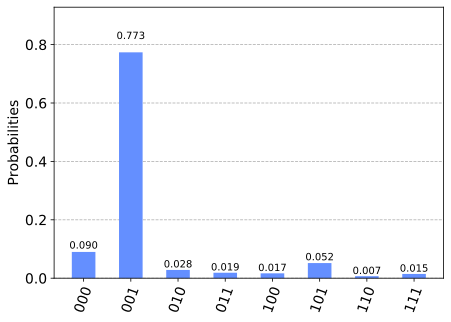

In [18]:
# Build noise model from backend properties
noise_model = NoiseModel.from_backend(backend_qc)

# Get coupling map from backend
coupling_map = backend_qc.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Perform a noise simulation
result = execute(circ, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
answer = result.get_counts(0)
plot_histogram(answer)

/home/jorgpym/anaconda3/envs/Qiskitenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0, 0.5, 'Probabilities')

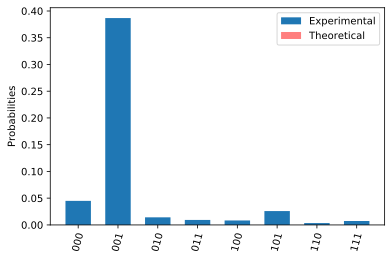

In [19]:
answer_dec = {bf_to_dec(key):value/shots for key, value in zip(answer.keys(), answer.values())}

t_answer_dec = {key:p(key, phase) for key in answer_dec.keys()}


plt.bar(answer_dec.keys(), answer_dec.values(), width=0.08, label='Experimental')
plt.bar(t_answer_dec.keys(), t_answer_dec.values(), alpha=0.5, width=0.04, color='red', label='Theoretical')
plt.xticks(list(answer_dec.keys()), list(answer.keys()),rotation=75)
plt.legend()
plt.ylabel('Probabilities')

In [20]:
# AVERAGE RULE: Take most probable value as an estimation
print('MAJORITY RULE')
print()
est_phase = max(answer_dec, key=answer_dec.get)
print('Estimated phase: {}'.format(est_phase))
print('Phase: {}'.format(round(phase, 3)))
print('Accuracy: {}'.format(round(np.abs(est_phase - phase), 3)))
print('2^-(t+1) = {}'.format(2**(-(t+1))))

MAJORITY RULE

Estimated phase: 0.125
Phase: 0.125
Accuracy: 0.0
2^-(t+1) = 0.0625


In [21]:
# First trigonometric moment about the mean direction

theta_1 = np.sum([value*np.exp(2*np.pi*1j*key) for key, value in zip(answer_dec.keys(), answer_dec.values())])


est_phase = np.abs(np.angle(theta_1)/(2*np.pi))

print('Estimated phase: {}'.format(est_phase))
print('Phase: {}'.format(round(phase, 3)))
print('Accuracy: {}'.format(round(np.abs(est_phase - phase), 3)))
print('2^-(t+2) = {}'.format(2**(-(t+2))))

mrl = np.absolute(theta_1)
sigma = np.sqrt(-2*np.log(mrl))/(2*np.pi)
print(sigma)

Estimated phase: 0.1184063924965857
Phase: 0.125
Accuracy: 0.007
2^-(t+2) = 0.03125
0.21702419123040365


# Running in QC

In [ ]:
def save(answer, filename='test'):
    '''
    Save the results obtained from running the circuit.
    
    Input: dictionary containing the results
    '''
    np.save(filename, [list(answer.keys()), list(answer.values())])

def load(filename='test'):
    l = np.load(filename + '.npy')
    return {key:float(value) for key,value in zip(l[0], l[1])}

filename = '{}-p{}-t{}'.format(backend, round(phase, 3), t)
if path.isfile(filename + '.npy'):
    answer = load(filename)
else:
    job = execute(circ, backend=backend_qc, shots=2048, optimization_level=3)
    job_monitor(job)
    # get the results from the computation
    results = job.result()
    answer = results.get_counts(circ)    
    save(answer, filename)

    
%config InlineBackend.figure_format = 'svg'
plot_histogram(answer)

Job Status: job is queued (15)    

Text(0, 0.5, 'Probabilities')

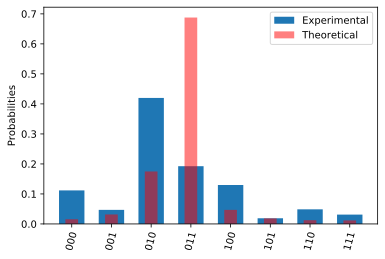

In [14]:
answer_dec = {bf_to_dec(key):value/shots for key, value in zip(answer.keys(), answer.values())}

t_answer_dec = {key:p(key, phase) for key in answer_dec.keys()}


plt.bar(answer_dec.keys(), answer_dec.values(), width=0.08, label='Experimental')
plt.bar(t_answer_dec.keys(), t_answer_dec.values(), alpha=0.5, width=0.04, color='red', label='Theoretical')
plt.xticks(list(answer_dec.keys()), list(answer.keys()),rotation=75)
plt.legend()
plt.ylabel('Probabilities')